# 3D DeepLabCut Toolbox
https://github.com/AlexEMG/DeepLabCut

This notebook will highlight the functionality of the newly released 3D project option (as of **2.0.7+**).

We recommend you look through these commands, and then you can easily modify this notebook for your own projects.

**In summary, the new functionality will:**
- allow you to calibrate your cameras using checkerboard images
- compute and fix camera distortions
- convert your 2D DeepLabCut tracking to 3D
- allow for plotting in 3D space

### Create a New 3D Project:

You will run this first function **one** time per project; a project is defined as a given set of cameras and calibration images. You can always analyze new videos within this project.

The function create_new_project_3d creates a new project directory specifically for converting the 2D pose to 3D pose, required subdirectories, and a basic 3D project configuration file. Each project is identified by the name of the project (e.g. Task1), name of the experimenter (e.g. YourName), as well as the date at creation.

Thus, this function requires the user to input the enter the name of the project, the name of the experimenter and number of cameras to be used. Currently, DeepLabCut supports triangulation using 2 cameras, but will expand to more than 2 cameras in a future version.

Optional arguments specify the working directory, i.e. where the project directory will be created. If the optional argument working_directory is unspecified, the project directory is created in the current working directory. Please note that the Full path of the 3D project configuration file will be referenced as ``config_path3d``.

NOTE: Be sure you are inside your DLC anaconda environment!

In [1]:
import deeplabcut
import sys

sys.path.append('/home/andy/Documents/DeepProprioception/Vision_Project')
from video_cut_functions import *

Loading DLC 2.2.1.1...


/home/andy/.local/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#Setup your project variables:
YourName = 'YH'
YourExperimentName = '20220801_DP01_emg'
main_folder = '/mnt/sdb2/DeepDraw/3DLC_project/'
working_directory = main_folder

In [3]:
config_path = deeplabcut.create_new_project_3d(YourExperimentName,YourName,num_cameras=2, working_directory = working_directory)

Created "/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/camera_matrix"
Created "/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/calibration_images"
Created "/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/undistortion"
Created "/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/corners"
Created "/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/removed_calibration_images"
Generated "/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/config.yaml"

A new project with name 20220801_DP01_emg-YH-2022-08-22-3d is created at /mnt/sdb2/DeepDraw/3DLC_project and a configurable file (config.yaml) is stored there. If you have not calibrated the cameras, then use the function 'calibrate_camera' to start calibrating the camera otherwise use the function ``triangulate`` to triangulate the dataframe


**TIP 1:** you can also pass ``working_directory='Full path of the working directory'`` if you want to place this folder somewhere beside the current directory you are working in.

**TIP 2:** you can also place config_path3d in front of deeplabcut.create_new_project_3d to create a variable that holds the path to the config.yaml file, i.e. ``config_path3d=deeplabcut.create_new_project_3d(...``

In [2]:
# If you're loading an already created project, just set the 3D Project config_path variable:
import os
from pathlib import Path
config_path = '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/config.yaml'
print(config_path)

/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/config.yaml


## Calibrate your cameras! 

(**CRITICAL!**) You must take images of a checkerboard to calibrate your images. Here are example boards you could print and use (mount them on a flat, hard surface!): https://markhedleyjones.com/projects/calibration-checkerboard-collection. 
- You must save the image pairs as **.jpg** files. 
- They should be named with the camera-# as the prefix, i.e. **camera-1-01.jpg** and **camera-2-01.jpg** for the first pair of images. 
- While taking the images:
     - Keep the orientation of the chessboard same and do not rotate more than 30 degrees. Rotating the chessboard circularly will change the origin across the frames and may result in incorrect order of detected corners.

     - Cover several distances, and within each distance, cover all parts of the image view (all corners and center).

     - Use a checkerboard as big as possible, ideally with at least 8x6 squares.

     - Aim for taking at least 70 pair of images as after corner detection, some of the images might need to be discarded due to either incorrect corner detection or incorrect order of detected corners.
     
#### DEMO images:
 
Here, we used a standard set along with this notebook. These images are a part of the Camera Calibration ToolBox for Matlab; specifically example 5: http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/example5.html 


If you wish to run this DEMO notebook, download the files and place inside the **calibration_images** directory. (To note, pairs 1 and 6 are not detected correctly, so please delete these images!). 


When acquiring calibration images from your own setup, it is recommended to take multiple pairs of image (around 50-70 pairs!).

The camera calibration is an **iterative process**, where the user needs to select a set of calibration images where the grid pattern is correctly detected. The function:``deeplabcut.calibrate_cameras(config_path)`` 
extracts the grid pattern from the calibration images and store them under the `corners` directory. The grid pattern could be 8x8 or 5x5 etc. We use a pattern of the 8x6 grid to find the internal corners of the checkerboard.

In some cases, it may happen that the corners are not detected correctly or the order of corners detected in the camera-1 image and camera-2 image is incorrect. We need to remove these pair of images as they will reduce the calibration accuracy.

**NEXT/if not done:** please place your (or demo) images into the **calibration_images** directory. 

### Edit the config.yaml file:
- change the camera names; i.e. if you do ""cam1, cam2"", or "camera-1, camera-2", or "left, right", etc.
- Note, that once this is set, you cannot edit these (they are used for other steps).

In [9]:
cbrow = 8
cbcol = 6
alpha = 0.8

In [12]:
deeplabcut.calibrate_cameras(config_path, cbrow = cbrow, cbcol =cbcol,calibrate=False,alpha=alpha)

Corners extracted! You may check for the extracted corners in the directory /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/corners and remove the pair of images where the corners are incorrectly detected. If all the corners are detected correctly with right order, then re-run the same function and use the flag ``calibrate=True``, to calbrate the camera.


NOTE: you need to specify how many rows (``cbrow``) and columns (``cbcol``) your checkerboard has (i.e. the intersection points - see demo images if unclear). Also, first set the variable ``calibrate`` to **False**, so you can remove any faulty images. You need to  visually inspect the output to check for the detected corners and select those pair of images where the corners are correctly detected. 

Once all the set of images are selected (namely, delete from the folder any bad pairs!) where the corners and their orders are detected correctly, then the two cameras can be calibrated using:

**They will look like this (one example frame):**
<p align="center">
<img src="https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/1559776966423-RATM6ZQT8JXHYAN768F6/ke17ZwdGBToddI8pDm48kKmw982fUOZVIQXHUCR1F55Zw-zPPgdn4jUwVcJE1ZvWQUxwkmyExglNqGp0IvTJZUJFbgE-7XRK3dMEBRBhUpw5XnxLBmEFHJGf_0qFdDpmIncOw4kq9OpCHNTYqzGO-E1YJr-Thht9Tdog4YtCwrE/right02_corner.jpg?format=500w" width="30%">
</p> 

Check your frames here below and remove the wrong corners. You can use the interactive buttons to navigate along the corner frames, when clicking on erase the calibration frames will be remove and not the corner frames.

In [26]:
%matplotlib notebook
calibration_dirname = os.path.join(os.path.dirname(config_path), 'calibration_images')
dirname = os.path.join(os.path.dirname(config_path), 'corners')
remove_corner_jupyter(dirname, calibration_dirname, start = 0)

Calibration images erased


Remove the unwanted frames with system commands. Sometimes for camera1 the frame does not exist already, it is because it got filtered out when checking for visible corners in camera2.

In [27]:
deeplabcut.calibrate_cameras(config_path, cbrow = cbrow, cbcol = cbcol, calibrate=True, alpha=alpha)

Saving intrinsic camera calibration matrices for camera-1 as a pickle file in /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/camera_matrix
Mean re-projection error for camera-1 images: 0.044 pixels 
Saving intrinsic camera calibration matrices for camera-2 as a pickle file in /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/camera_matrix
Mean re-projection error for camera-2 images: 0.067 pixels 
Computing stereo calibration for 
Saving the stereo parameters for every pair of cameras as a pickle file in /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/camera_matrix
Camera calibration done! Use the function ``check_undistortion`` to check the check the calibration


## Check for Undistortion:

In order to check how well the stereo calibration is, it is recommended to undistort the calibration images and the corner points using camera matrices and project these undistorted points on the undistorted images to check if they align correctly. This can be done in deeplabcut as:


All images are undistorted and stored in /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/undistortion
Use the function ``triangulate`` to undistort the dataframes and compute the triangulation


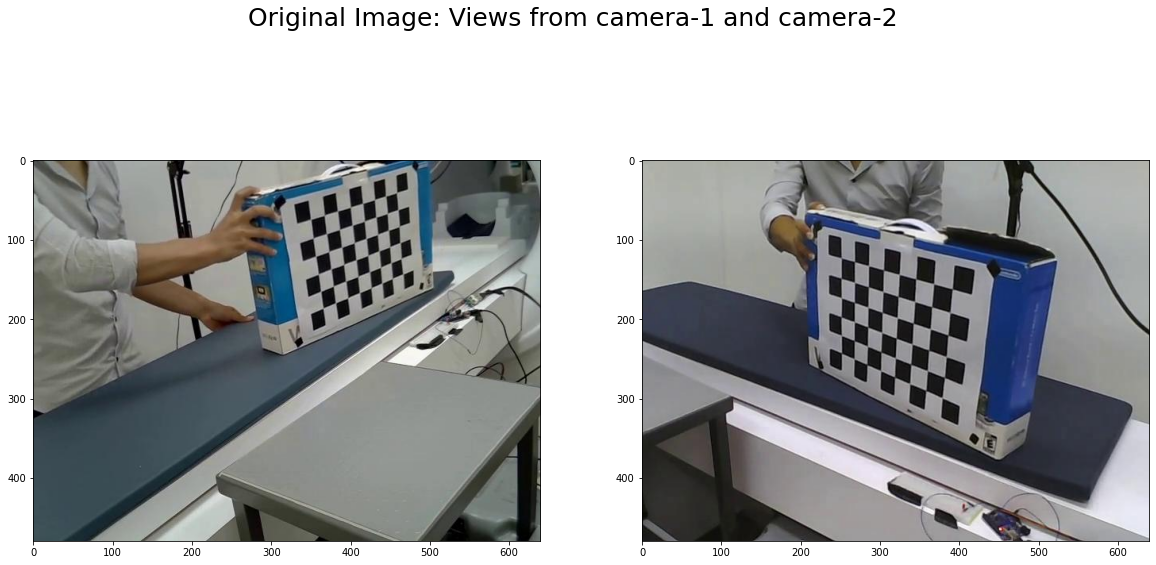

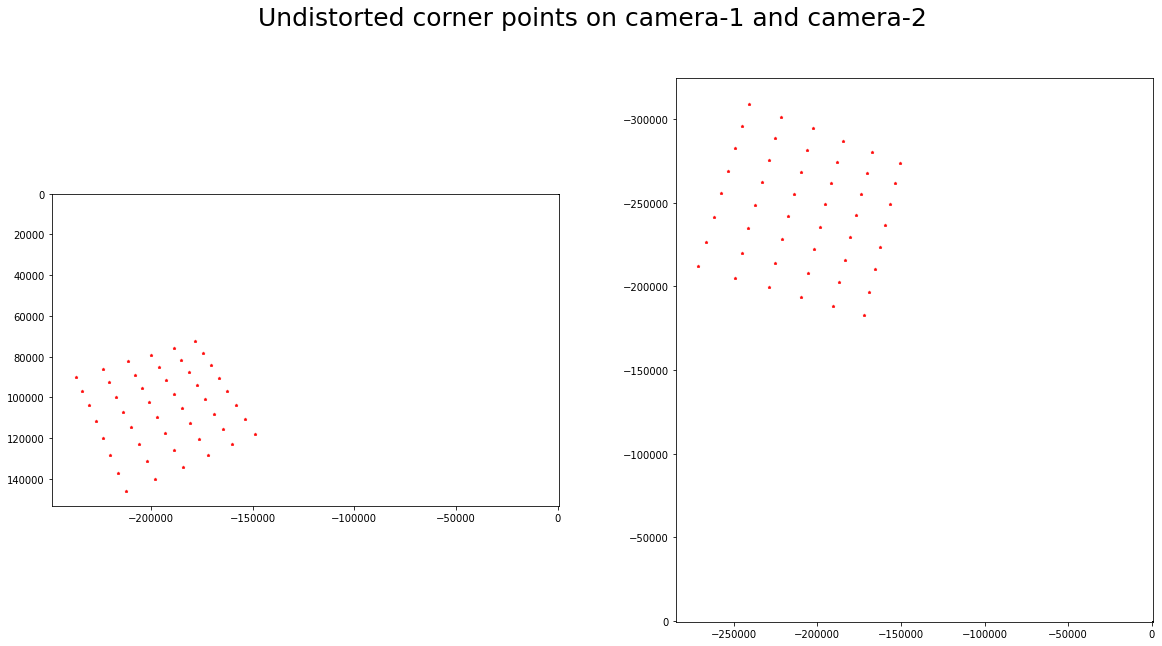

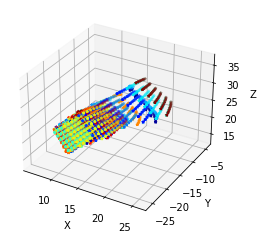

In [28]:
import matplotlib
%matplotlib inline

deeplabcut.check_undistortion(config_path)

Each calibration image is undistorted and saved under the directory ``undistortion``. A plot with a pair of undistorted camera images with its undistorted corner points overlaid is also stored. Please visually inspect this image. All the undistorted corner points from all the calibration images are triangulated and plotted for the user to visualize for any undistortion related errors. If they are not correct, go check and revise the calibration images (then repeat the calirbation and this step)!

## Triangulation --> converting your 2D to 3D! 

If there are no errors in the undistortion, then the pose from the 2 cameras can be triangulated to get the 3D DeepLabCut coordinates!

(**CRITICAL!**) Name the video files in such a way that the file name contains the name of the cameras as specified in the ``config file``. e.g. if the cameras as named as ``camera-1`` and ``camera-2`` (or ``cam-1``, ``cam-2`` etc.) then the video filename must contain this naming, i.e. this could be named as ``rig-1-mouse-day1-camera-1.avi`` and ``rig-1-mouse-day1-camera-2.avi``. Notably, the videos do not need to be the same pixel size, but be sure they are similar in size to the calibration images (and they must be the same cameras used for calibration).

##  (**CRITICAL!**) Edit the config.yaml file: 
You must also edit the **3D project config.yaml** file to denote which DeepLabCut projects have the information for the 2D views. 

 - Of critical importance is that you need to input the **same** body part names as in the config.yaml file of the 2D project.
- You must set the snapshot to use inside the 2D config file (default is -1, namely the last training snapnot of the network). 
- You need to set a "scorer 3D" name; this will point to the project file and be set in future 3D output file names.
- You should define a "skeleton" here as well (note, this is not rigid, it just connects the points in the plotting step). Not every point needs to be "skeletonized", i.e. these points can be a subset of the full body parts list. The other points will just be plotted into the 3D space.



**Next,** pass the ``config_path3d`` and now the ``video_path``, which is the path to the **folder** where all the videos from two cameras are stored. The triangulation can be done in deeplabcut by typing:

In [29]:
import sys
import ruamel.yaml

# Change path to trained network DLC config file here
path_to_2Dconfig = "/mnt/sdb2/DeepDraw/DLC_project/20220801_DP01_emg-YH-2022-08-18/config.yaml"

# You don't have to change anything here
yaml = ruamel.yaml.YAML()
with open(config_path) as fp:
    data = yaml.load(fp)
data["skeleton"] = [['Shoulder','Elbow'],['Elbow', 'Wrist']]
data["config_file_camera-1"] = path_to_2Dconfig
data["config_file_camera-2"] = path_to_2Dconfig
data["dotsize"] = 7

yaml.dump(data, sys.stdout)
with open(config_path, 'w') as fp:
    yaml.dump(data, fp)

# Project definitions (do not edit)
Task: 20220801_DP01_emg
scorer: YH
date: Aug22

# Project path (change when moving around)
project_path: /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d

# Plotting configuration
skeleton:     # Note that the pairs must be defined, as you want them linked!
- -
    Shoulder
  - Elbow
- - Elbow
  - Wrist
skeleton_color: black
pcutoff: 0.4
colormap: jet
dotsize: 7
alphaValue: 0.8
markerType: '*'
markerColor: r

# Number of cameras, camera names, path of the config files, shuffle index and trainingsetindex used to analyze videos:
num_cameras: 2
camera_names:
- camera-1
- camera-2
scorername_3d: DLC_3D # Enter the scorer name for the 3D output
trainingsetindex_camera-1: 0
trainingsetindex_camera-2: 0
config_file_camera-1: /mnt/sdb2/DeepDraw/DLC_project/20220801_DP01_emg-YH-2022-08-18/config.yaml
config_file_camera-2: /mnt/sdb2/DeepDraw/DLC_project/20220801_DP01_emg-YH-2022-08-18/config.yaml
shuffle_camera-1: 1
shuffle_camera-2: 1


In [30]:
# src = os.path.join(os.path.dirname(path_to_2Dconfig), 'videos/*_str.mp4')

video_path = os.path.join(os.path.dirname(config_path),'videos')
os.makedirs(video_path, exist_ok = True)
if os.path.exists(os.path.join(video_path, "token_check")):
    print("The files were already copied")
else: 
    for cam_num in range(1,3):
        src = os.path.join("/mnt/sdb2/DeepDraw/Projects", os.path.basename(os.path.dirname(config_path).split('-')[0]),"Camera_{}".format(cam_num),"Video_cut/*")
        print(src)
        os.system("cp {} {}".format(src, video_path))
    for file in os.listdir(video_path):
        if file.endswith(".mp4"):
            if file.endswith("labeled.mp4"):
                os.system("rm {}".format(os.path.join(video_path, file)))
            else:
                cam_num = int(list(file.split('_')[3])[-1])
                output_name, ext = os.path.splitext(file)
                output_name = '_'.join(output_name.split("_cam_{}_".format(cam_num)))
                output_name = output_name + '-camera-{}'.format(cam_num) + ext
                os.system("mv {} {}".format(os.path.join(video_path, file),os.path.join(video_path, output_name)))
        if file.endswith(".h5") or file.endswith(".pickle"):
            cam_num = int(list(file.split('_')[3])[-1])
            output_name, ext = os.path.splitext(file)
            output_name = '_'.join(output_name.split("_cam_{}_".format(cam_num)))
            list_name = output_name.split('_')[0:3]
            run_num = int(list(output_name.split('_')[3])[0])
            list_name.append('{}-camera-{}{}'.format(run_num,cam_num, ''.join(list(output_name.split('_')[3])[1:])))
            list_name.extend(output_name.split('_')[4:])
            output_name = '_'.join(list_name) + ext
            os.system("mv {} {}".format(os.path.join(video_path, file),os.path.join(video_path, output_name)))
    os.system("touch {}".format(os.path.join(video_path, "token_check")))

The files were already copied


In [31]:
# Of course, this does not work on the demo calibration images, 
# but when you are ready for your own dataset, edit and then run the following!
from time import time
t1 = time()
deeplabcut.triangulate(config_path,video_path, videotype='mp4')
t2 = time()
print(t1-t2)

List of pairs: [['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4'], ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_2-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_2-camera-2.mp4'], ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_100_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_100_run_1-camera-2.mp4'], ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_100_run_2-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_100_run_2-camera-2.mp4'], ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_101_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_

Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_101_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_101_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_101_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_101_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulat

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_106_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_106_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_106_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_107_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Check

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_111_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_111_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_111_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_111_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Check

Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_117_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_117_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_117_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_117_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulat

This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_121_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_121_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_122_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_122_run_1-camera-1
This file is already ana

This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_127_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_127_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_127_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_127_run_2-camera-2
This file is already ana

Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_132_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_132_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_132_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_132_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for vi

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_137_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_138_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_138_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_138_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Check

This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_142_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_142_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_142_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_142_run_2-camera-2
This file is already ana

Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_148_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_148_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_148_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_148_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for vi

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_152_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_153_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_153_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_153_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Check

Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_18_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_18_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_18_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_18_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation.

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_23_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_23_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_23_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_23_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking 

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_28_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_29_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_29_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_29_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking 

This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_33_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_33_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_33_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_33_run_2-camera-2
This file is already analyze

Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_39_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_39_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_39_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_39_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation.

This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_43_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_43_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_44_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_44_run_1-camera-1
This file is already analyze

This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_49_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_49_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_49_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_49_run_2-camera-2
This file is already analyze

Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_54_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_54_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_54_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_54_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video 

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_59_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_5_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_5_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_5_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the

This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_64_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_64_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_64_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_64_run_2-camera-2
This file is already analyze

Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_6_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_6_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_6_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_6_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
T

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_74_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_74_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_74_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_75_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking 

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_7_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_7_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_7_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_7_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the 

This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_85_run_1-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_85_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_85_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_85_run_1-camera-2
This file is already analyze

Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_8_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_8_run_2-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_8_run_2-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_8_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
T

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_95_run_1-camera-1
This file is already analyzed!
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_95_run_1-camera-2.mp4 using config_file_camera-2
Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_95_run_1-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
Analyzing video /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_95_run_2-camera-1.mp4 using config_file_camera-1
Already analyzed...Checking 

Already analyzed...Checking the meta data for any change in the camera matrices and/or scorer names cut_9_run_2-camera-2
This file is already analyzed!
Undistorting...
Computing the triangulation...
Triangulated data for video ['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-1.mp4', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1-camera-2.mp4']
Results are saved under:  /mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos
All videos were analyzed...
Now you can create 3D video(s) using deeplabcut.create_labeled_video_3d
-17.280815362930298


The **triangulated file** is now saved under the same directory where the video files reside (or you passed a destination folder path)! These files can now be used for future analysis. This step can now be run at anytime as you collect new videos, and easily added to your automated analysis pipeline, i.e. such as using``deeplabcut.triangulate(config_path3d, video_path)`` instead of ``deeplabcut.analyze_videos``

## Visualize your 3D DeepLabCut Videos:

In order to visualize the pose in 3D, the user can create a 3D video for certain frames (these are large files, so we advise just looking at a subset of frames). The user can specify the path of the triangulated file and specify the start and end frame indices to create a 3D labeled video. Note that the triangulated_file is the newly created file that ends with yourDLC_3D_scorername.h5. This can be done using:

In [32]:
path_to_h5 = []
for file in os.listdir(video_path):
    if file.endswith(".h5"):
        if file.endswith("_filtered.h5"):
            continue
        iscamera = file.split("_")[3]
        if iscamera.startswith('1-camera') or iscamera.startswith('2-camera') or iscamera.startswith("3-camera"):
            continue
        path_to_h5.append(os.path.join(video_path,file))
print(path_to_h5)
# deeplabcut.create_labeled_video_3d(config_path, path_to_h5, videofolder = video_path, videotype= 'mp4',trailpoints=0, start=0, end=100)

['/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_1_DLC_3D.h5', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_0_run_2_DLC_resnet50_20220801_DP01_emgAug18shuffle1_30000.h5', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_100_run_1_DLC_resnet50_20220801_DP01_emgAug18shuffle1_30000.h5', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_100_run_2_DLC_resnet50_20220801_DP01_emgAug18shuffle1_30000.h5', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_101_run_1_DLC_resnet50_20220801_DP01_emgAug18shuffle1_30000.h5', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_101_run_2_DLC_resnet50_20220801_DP01_emgAug18shuffle1_30000.h5', '/mnt/sdb2/DeepDraw/3DLC_project/20220801_DP01_emg-YH-2022-08-22-3d/videos/cut_102_run_1_DLC_resnet50_20220801_DP01_emgAug18shuffle1_30000.h5', '/mnt/sdb2/DeepDraw/3DLC_project/20220

<IPython.core.display.Javascript object>


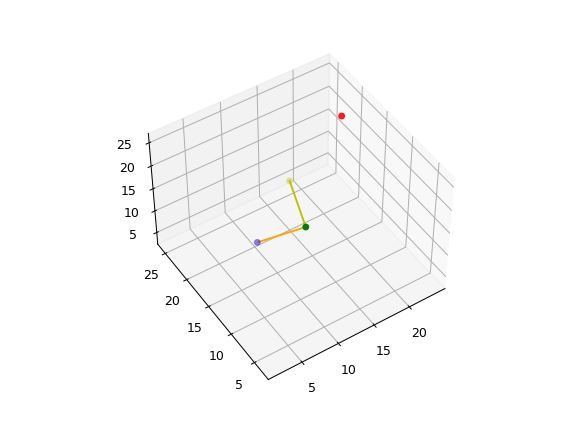

6.440993996471466 6.212692178011056


In [33]:
# Check 3D resutls
%matplotlib notebook
import h5py
import numpy as np
import matplotlib.pyplot as plt
import itertools
filename = path_to_h5[60]
start = 50
arm_ind = [0,1,2]
with h5py.File(filename, "r") as f:
    # List all groups
    a_group_key = list(f.keys())[0]
    # Get the data
    data = list(f[a_group_key]['table'])
    k = 0
    for i in range(start,len(data)):
        points = data[i]
        markers = np.reshape(points[1], (-1,3))
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        ax.scatter(markers[:,0], -markers[:,1], markers[:,2], c = ['b','g','y','r'])
        ax.plot([markers[arm_ind[0],0], markers[arm_ind[1],0]],[-markers[arm_ind[0],1], -markers[arm_ind[1],1]], [markers[arm_ind[0],2], markers[arm_ind[1],2]], c= 'orange')
        ax.plot([markers[arm_ind[1],0], markers[arm_ind[2],0]], [-markers[arm_ind[1],1], -markers[arm_ind[2],1]], [markers[arm_ind[1],2], markers[arm_ind[2],2]], c= 'y')
        cube_side = 2*(np.linalg.norm(markers[0,:]-markers[-1,:]))
        mins = [markers[0,0]-cube_side/3, markers[0,1]+cube_side/5, markers[0,2]-cube_side/2]
        maxes = np.add(mins, [cube_side, cube_side, cube_side])  # [700,1100,-600]
        corners = np.array(list(itertools.product(*zip(mins, maxes))))
        ax.scatter3D(corners[:, 0], corners[:, 1], corners[:, 2], s=0, c='w')
        
        # plt.savefig(os.path.join(output_dir, 'frame_{}'.format(k)))
        # plt.close(fig)
        print(np.linalg.norm(markers[1,:]-markers[0,:]), np.linalg.norm(markers[2,:]-markers[1,:]))
        plt.show()
        k += 1
        break


<IPython.core.display.Javascript object>


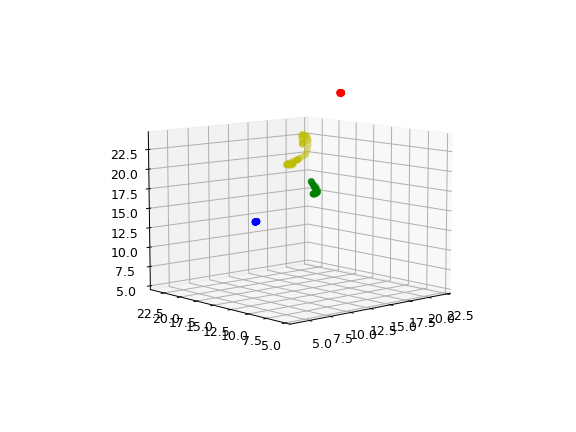

In [34]:
trajectories = []
for i in range(start,len(data)):
        points = data[i]
        markers = np.reshape(points[1], (-1,3))
        trajectories.append(markers)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for markers in trajectories:
    cube_side = 2*(np.linalg.norm(markers[0,:]-markers[-1,:]))
    mins = [markers[0,0]-cube_side/3, markers[0,1]+cube_side/5, markers[0,2]-cube_side/2]
    maxes = np.add(mins, [cube_side, cube_side, cube_side])  # [700,1100,-600]
    corners = np.array(list(itertools.product(*zip(mins, maxes))))
    ax.scatter3D(corners[:, 0], corners[:, 1], corners[:, 2], s=0, c='w')
    ax.scatter(markers[:, 0], -markers[:, 1], markers[:, 2], c=['b','g','y','r'], alpha = 0.2)
plt.show()

### Copy results to project folder

If you are satisfied with your results, you can copy them in the project folder for following OpenSim analysis

In [63]:
project_path = os.path.join("/mnt/sdb2/DeepDraw/Projects", os.path.basename(os.path.dirname(config_path).split('-')[0]))
os.makedirs(os.path.join(project_path,"3DLC_results"), exist_ok = True)
for file in path_to_h5:
    src = os.path.join(video_path, file)
    dst = os.path.join(project_path,"3DLC_results")
    os.system("cp {} {}".format(src, dst))